# History

- Data Cleaning
- Descriptive Statistics
- Grouping by Proxies
- Selecting Specific Items

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import time
from datetime import datetime
from datetime import timezone

%matplotlib inline

In [2]:
# Reading the data from history revisions and history items
revisions = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/history_revisions.csv')
items = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data/history.csv')

In [3]:
print("Number of Revisions in History Dataset")
print(revisions.shape)
print("Number of Wikidata Items in History Dataset")
print(items.shape)

Number of Revisions in History Dataset
(87913, 12)
Number of Wikidata Items in History Dataset
(31190, 3)


# Data Cleaning

In [4]:
# Dropping unecessary columns from the revisions dataframe
rev = revisions.drop(['pageid', 'type', 'editentity', 'parentid'], axis=1)

In [5]:
# Method to assign edit types to each revision by using the revision comment
def get_edit_type(comment):
    # Decoding the comment from a bytes object to a string
    # c = comment.decode("utf-8").lower()
    
    # Converting the comment to lowercase
    c = comment.lower()
    edit_type = '' 
    
    if c == '':
        return edit_type
    
    if "|" in c:
        # Comments which have |
        # Extracting initial edit summary and removing /*
        cc = c.split("|")[0].replace("/* ", "")
        if 'undo' in cc:
            edit_type = 'undo'
            return edit_type
        elif 'restore' in cc:
            edit_type = 'restore'
            return edit_type
        elif 'wbsetclaimvalue' in cc:
            edit_type = 'set'
            return edit_type
        elif 'wbsetlabeldescriptionaliases' in cc:
            edit_type = 'set'
            return edit_type
        elif 'wbcreateredirect' in cc:
            edit_type = 'create'
            return edit_type
        elif 'merge' in cc:
            edit_type = 'merge'
            return edit_type
        elif '-' in cc:
            ccc = cc.split("-")[1]
            if 'create' in ccc:
                edit_type = 'create'
                return edit_type
            elif 'add' in ccc:
                edit_type = 'add'
                return edit_type
            elif 'set' in ccc:
                edit_type = 'set'
                return edit_type
            elif 'update' in ccc:
                edit_type = 'update'
                return edit_type
            elif 'remove' in ccc:
                edit_type = 'remove'
                return edit_type
    if 'revert' in c: 
        edit_type = 'revert'
        return edit_type  
    elif 'protect' in c:
        edit_type = 'protect'
        return edit_type  
    elif 'undid' in c:
        edit_type = 'undo'
        return edit_type      
    return edit_type
        

In [6]:
# Assigning edit types to each revision
rev['type'] = [get_edit_type(comment) for comment in rev['comment']]

In [7]:
rev.shape

(87913, 9)

In [8]:
# Removing revisions with empty types - empty comments or edge cases
to_remove = rev[rev['type'] == ''].index
rev = rev.drop(to_remove)

In [9]:
# Reading csv with bot names scraped from Wikidata
bots = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/wikidata_bots.csv')

In [10]:
# Method to assign user types to revisions
# 3 types: Registered, Anonymous, Bot
def get_user_type(user):
    
    # Remove preceeding b from storing as a bytes object
    # Replace ' with empty character
    u = user[1:].replace("'", "")
    
    user_type = ''
    
    if u == "":
        user_type = 'Anonymous'
        return user_type
    elif u in bots.values:
        user_type = 'Bot'
        return user_type
    else: 
        user_type = 'Registered'
        return user_type
    return user_type
    

In [11]:
# Assigning user types to revisions
rev['usertype'] = [get_user_type(user) for user in rev['username']]

In [12]:
# Need to recalculate editcount for the items
# Drop old editcount column
rev = rev.drop(['editscount'], axis=1)

In [13]:
editscount = rev['qid'].value_counts()

In [14]:
editscount.describe()

count    31055.000000
mean         2.809048
std          5.688518
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        322.000000
Name: qid, dtype: float64

In [15]:
# Converting to a dataframe so that it can be compared/merged with original dataframe
df_editscount = pd.DataFrame({'qid':editscount.index, 'editscount':editscount.values})

In [16]:
print('Items with No of Edits = 1')
print(len(df_editscount[df_editscount['editscount'] == 1]))

print('Items with No of Edits = 2')
print(len(df_editscount[df_editscount['editscount'] == 2]))

print('Items with No of Edits = 3')
print(len(df_editscount[df_editscount['editscount'] == 3]))

print('Items with No of Edits = 4')
print(len(df_editscount[df_editscount['editscount'] == 4]))

print('Items with No of Edits = 5')
print(len(df_editscount[df_editscount['editscount'] == 5]))

print('Items with No of Edits <= 5')
print(len(df_editscount[df_editscount['editscount'] <= 5]))

Items with No of Edits = 1
12923
Items with No of Edits = 2
9346
Items with No of Edits = 3
3329
Items with No of Edits = 4
1934
Items with No of Edits = 5
772
Items with No of Edits <= 5
28304


In [17]:
# Removing items with editscount <= 5 
to_remove = df_editscount[df_editscount['editscount'] <= 5].index
df_editscount = df_editscount.drop(to_remove)

In [18]:
df_editscount.shape

(2751, 2)

In [19]:
# Removing all items with editscount <= 5 from revisions dataset
# Removing by finding intersection on qid between bot sets
rev = pd.merge(rev, df_editscount, how='inner', on=['qid'])

In [20]:
# Converting the timestamps to datetime object
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

# Converting to datetime leaves the dates in form '2016-10-12 14:37:53+00:00'
# Formatting timestamp to remove +00:00
rev['timestamp'] = rev['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# strftime() returns a string object
# Converting back to datetime
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

In [21]:
rev.dtypes

Unnamed: 0             int64
qid                   object
revisionid           float64
timestamp     datetime64[ns]
comment               object
userid               float64
username              object
type                  object
usertype              object
editscount             int64
dtype: object

In [22]:
print(df_editscount.head())
print(df_editscount[df_editscount['qid'] == 'Q52'])
print(df_editscount[df_editscount['qid'] == 'Q2013'])

         qid  editscount
0     Q77389         322
1  Q11718707         316
2   Q3126992         310
3   Q2476721         309
4   Q1565364         241
Empty DataFrame
Columns: [qid, editscount]
Index: []
Empty DataFrame
Columns: [qid, editscount]
Index: []


In [23]:
print("Number of Revisions in History Dataset after Data Cleaning")
print(rev.shape)
print("Number of Wikidata Items in History Dataset after Data Cleaning")
history_items = rev['qid'].value_counts()
print(history_items.shape)

Number of Revisions in History Dataset after Data Cleaning
(34037, 10)
Number of Wikidata Items in History Dataset after Data Cleaning
(2751,)


# Descriptive Statistics

In [24]:
print(history_items.describe().astype(int))

count    2751
mean       12
std        15
min         6
25%         7
50%         9
75%        13
max       322
Name: qid, dtype: int32


In [25]:
# Converting a series to a dataframe
h_items = pd.DataFrame({'type':history_items.index, 'count':history_items.values})

In [26]:
# Items between the median and 75th percentile
print(h_items[(h_items['count'] >= 9) & (h_items['count'] < 13)])
# Items in the top 25% of the dataset
print(h_items[h_items['count'] >= 13])
# Items below median that is items that fall in the fist 50%
print(h_items[h_items['count'] < 9])
# Items that form the low 25% of the dataset
print(h_items[h_items['count'] < 7])
# Items that are part of 75% of the dataset
print(h_items[h_items['count'] < 13])

           type  count
743   Q11642793     12
744   Q16330094     12
745     Q311462     12
746    Q4531993     12
747   Q10307125     12
...         ...    ...
1443   Q7290505      9
1444   Q2896243      9
1445  Q27875935      9
1446     Q82972      9
1447     Q70026      9

[705 rows x 2 columns]
          type  count
0       Q77389    322
1    Q11718707    316
2     Q3126992    310
3     Q2476721    309
4     Q1565364    241
..         ...    ...
738  Q20510245     13
739    Q369562     13
740    Q105121     13
741   Q1730588     13
742   Q5992356     13

[743 rows x 2 columns]
           type  count
1448  Q16727393      8
1449   Q4202529      8
1450  Q28049529      8
1451   Q6813070      8
1452   Q1064413      8
...         ...    ...
2746  Q27989127      6
2747  Q27989143      6
2748   Q2942991      6
2749  Q27038338      6
2750   Q2851520      6

[1303 rows x 2 columns]
           type  count
2139  Q12295543      6
2140  Q21543012      6
2141  Q11714520      6
2142    Q314963    

# Statistics for Proxies

In [27]:
# Counting the value of the number of proxies that exist in the dataset
type_stats = rev['type'].value_counts()

In [28]:
# Converting a series to a Dataframe
type_s = pd.DataFrame({'type':type_stats.index, 'count':type_stats.values})
ts = type_s.set_index('type')
print(ts)

         count
type          
create   16463
add      10901
update    4021
remove    1216
set       1196
revert     102
undo        57
merge       52
restore     27
protect      2


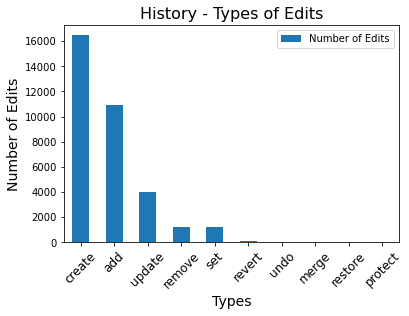

In [29]:
# Plotting the statistics for the proxies in the dataset
ax = ts.plot.bar()

plt.title('History - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

In [30]:
# Extracting select proxies: remove, restore, revert, merge, undo, protect
controversial_proxies = ts.iloc[[3, 5, 6, 7, 8, 9]]
# print(controversial_proxies)

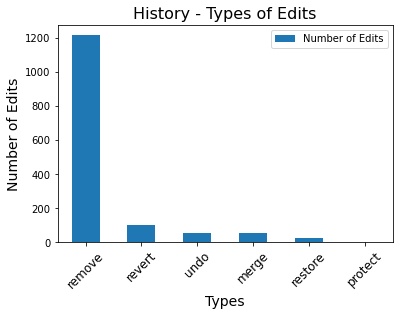

In [31]:
# Plotting select proxies
ax = controversial_proxies.plot.bar()

plt.title('History - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

In [32]:
# Extracting select proxies: restore, revert, merge, undo, protect
controversial_proxies_without_remove = ts.iloc[[5, 6, 7, 8, 9]]
print(controversial_proxies_without_remove)

         count
type          
revert     102
undo        57
merge       52
restore     27
protect      2


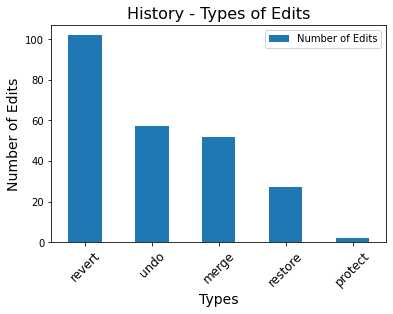

In [33]:
# Plotting select proxies without remove
ax = controversial_proxies_without_remove.plot.bar()

plt.title('History - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

# Statistics for No of Edits

In [34]:
no_of_edits = history_items.to_numpy()

(array([1.557e+03, 4.510e+02, 2.520e+02, 1.550e+02, 1.010e+02, 6.100e+01,
        5.600e+01, 2.200e+01, 1.200e+01, 1.500e+01, 9.000e+00, 6.000e+00,
        1.100e+01, 2.000e+00, 3.000e+00, 3.000e+00, 4.000e+00, 3.000e+00,
        2.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        4.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

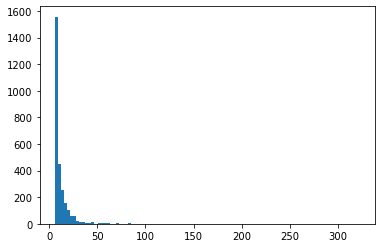

In [35]:
# Exploring distribution of number of edits
plt.hist(no_of_edits, 100)

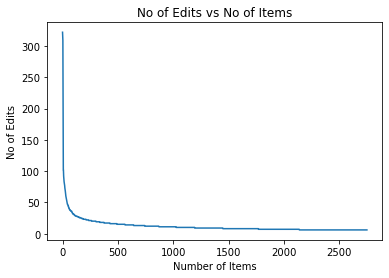

In [36]:
# Plotting No of Edits for the Items in the dataset 
# Line Plot

plt.plot(no_of_edits)

plt.title("No of Edits vs No of Items")
plt.xlabel("Number of Items")
plt.ylabel("No of Edits")

plt.show()

# Grouping by Proxies

In [37]:
reverts = rev["type"].str.contains("revert")
revert_edits = reverts.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [38]:
merges = rev["type"].str.contains("merge")
merge_edits = merges.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [39]:
undos = rev["type"].str.contains("undo")
undo_edits = undos.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [40]:
restores = rev["type"].str.contains("restore")
restore_edits = restores.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [41]:
protects = rev["type"].str.contains("protect")
protect_edits = protects.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [42]:
removes = rev["type"].str.contains("remove")
remove_edits = removes.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [43]:
# Creating a dataframe which will contain qids for items and no of each proxy
proxies = pd.DataFrame({'revert': revert_edits, 'merge': merge_edits, 'undo': undo_edits, 'restore': restore_edits, 
                        'protect': protect_edits, 'remove': remove_edits})

In [44]:
proxies = proxies.reset_index()

In [45]:
proxies.columns

Index(['qid', 'revert', 'merge', 'undo', 'restore', 'protect', 'remove'], dtype='object')

In [46]:
df_editscount.columns

Index(['qid', 'editscount'], dtype='object')

In [47]:
# Adding editscount for each item 
proxies = pd.merge(proxies, df_editscount, how='inner', on=['qid'])

In [48]:
# Counting the number of users per item that is userscount
rev_users = rev.groupby('qid')['username'].nunique()
# Converting to a dataframe so that it can be compared/merged 
df_userscount = pd.DataFrame({'qid':rev_users.index, 'userscount':rev_users.values})

In [49]:
# Adding userscount for each item 
proxies = pd.merge(proxies, df_userscount, how='inner', on=['qid'])

In [50]:
proxies.describe()

,revert,merge,undo,restore,protect,remove,editscount,userscount
count,2751.000000,2751.000000,2751.00000,2751.000000,2751.000000,2751.000000,2751.000000,2751.000000
mean,0.037077,0.018902,0.02072,0.009815,0.000727,0.442021,12.372592,3.065431
std,0.367902,0.141443,0.19430,0.121708,0.026958,1.124682,15.935017,1.932330
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,6.000000,1.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,7.000000,2.000000
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,9.000000,3.000000
75%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,13.000000,4.000000
max,10.000000,2.000000,5.00000,3.000000,1.000000,26.000000,322.000000,33.000000


Text(0, 0.5, 'No of Edits')

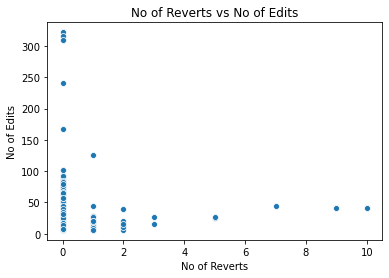

In [52]:
ax = sns.scatterplot(x="revert", y="editscount", data=proxies)
ax.set_title("No of Reverts vs No of Edits")
ax.set_xlabel("No of Reverts")
ax.set_ylabel("No of Edits")

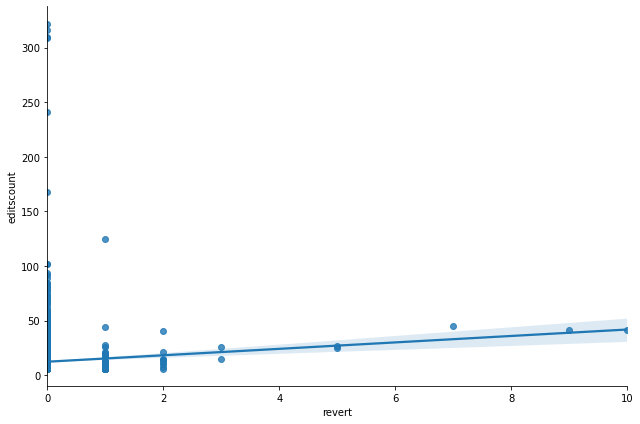

In [53]:
sns.lmplot(x="revert", y="editscount", data=proxies, height=6, aspect=1.5)

In [54]:
corr_matrix = proxies.corr()
corr_matrix

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,0.112311,0.299557,0.674046,0.510582,0.064958,0.068106,0.319349
merge,0.112311,1.000000,0.051902,0.073714,0.187127,0.068611,-0.002642,0.120537
undo,0.299557,0.051902,1.000000,0.145170,0.066546,0.114494,0.057521,0.120360
restore,0.674046,0.073714,0.145170,1.000000,0.330316,0.037366,0.058863,0.244662
protect,0.510582,0.187127,0.066546,0.330316,1.000000,-0.010603,0.034922,0.131719
remove,0.064958,0.068611,0.114494,0.037366,-0.010603,1.000000,0.202575,0.256078
editscount,0.068106,-0.002642,0.057521,0.058863,0.034922,0.202575,1.000000,0.161471
userscount,0.319349,0.120537,0.120360,0.244662,0.131719,0.256078,0.161471,1.000000


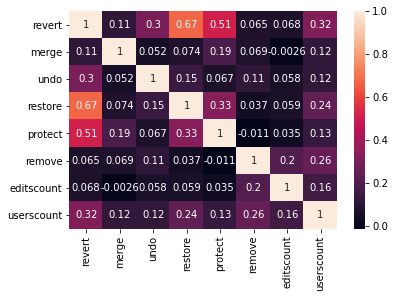

In [55]:
sns.heatmap(corr_matrix, annot=True)

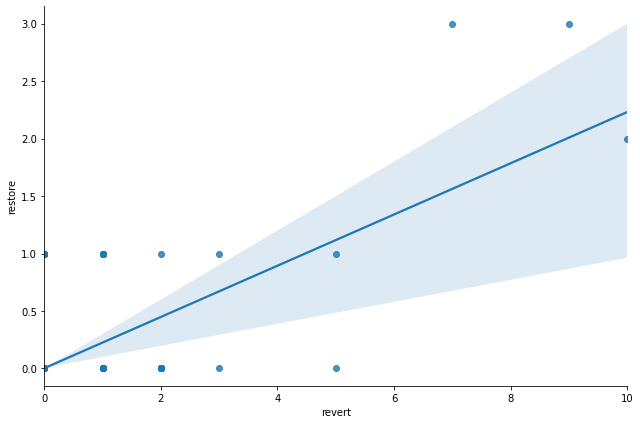

In [56]:
# restore and revert have positive correlation
sns.lmplot(x="revert", y="restore", data=proxies, height=6, aspect=1.5)

Text(0, 0.5, 'No of Edits')

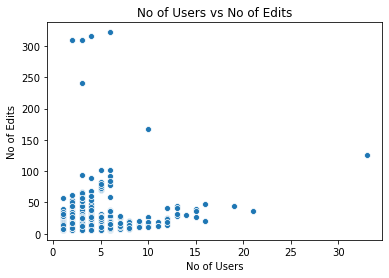

In [57]:
ax = sns.scatterplot(x="userscount", y="editscount", data=proxies)
ax.set_title("No of Users vs No of Edits")
ax.set_xlabel("No of Users")
ax.set_ylabel("No of Edits")

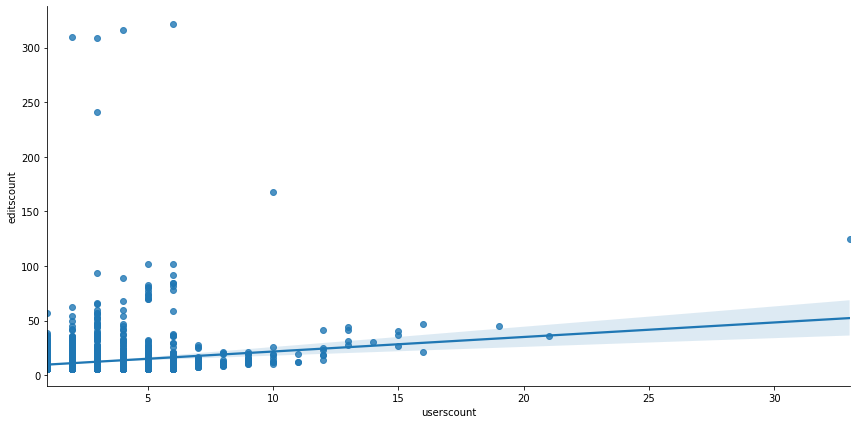

In [58]:
sns.lmplot(x="userscount", y="editscount", data=proxies, height=6, aspect=2)

In [59]:
# Removing items with 0 reverts, merges, undos, restores, removes, protects
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0) & 
                   (proxies['remove'] == 0) & (proxies['protect'] == 0)].index
proxies = proxies.drop(to_remove)

In [60]:
proxies.shape

(749, 9)

In [61]:
# Items which only have edits under remove and are 0 for the remaining proxies
proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)]

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
10,Q2226193,0,0,0,0,0,1,6,4
13,Q2264242,0,0,0,0,0,1,13,3
18,Q2317246,0,0,0,0,0,1,8,5
27,Q2426431,0,0,0,0,0,2,9,4
35,Q2449920,0,0,0,0,0,1,23,1
...,...,...,...,...,...,...,...,...,...
2725,Q28060026,0,0,0,0,0,1,7,1
2734,Q28070854,0,0,0,0,0,2,27,2
2735,Q28071234,0,0,0,0,0,1,9,1
2736,Q28072639,0,0,0,0,0,2,34,1


In [62]:
# Removing items with only edits under remove
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)].index
proxies_without_remove = proxies.drop(to_remove)

In [63]:
proxies_without_remove.shape

(140, 9)

In [64]:
corr = proxies_without_remove.corr()
corr

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,-0.189023,0.123955,0.619054,0.514314,-0.016614,0.193355,0.409230
merge,-0.189023,1.000000,-0.295218,-0.166367,0.147824,-0.063869,-0.168324,-0.136566
undo,0.123955,-0.295218,1.000000,-0.018350,0.014625,0.077250,0.142601,-0.046301
restore,0.619054,-0.166367,-0.018350,1.000000,0.311218,-0.041514,0.167054,0.291524
protect,0.514314,0.147824,0.014625,0.311218,1.000000,-0.055994,0.113510,0.191532
remove,-0.016614,-0.063869,0.077250,-0.041514,-0.055994,1.000000,0.602674,0.416036
editscount,0.193355,-0.168324,0.142601,0.167054,0.113510,0.602674,1.000000,0.491058
userscount,0.409230,-0.136566,-0.046301,0.291524,0.191532,0.416036,0.491058,1.000000


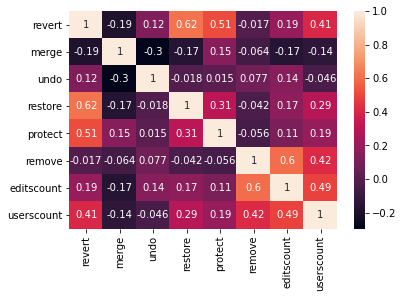

In [106]:
sns.heatmap(corr, annot=True)

# Top 20 

## Top 20 Reverts

In [66]:
top20_reverts = proxies_without_remove.nlargest(20, 'revert')

In [67]:
top20_reverts

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
141,Q6534,10,0,3,2,0,2,41,12
157,Q15975,9,1,1,3,1,0,41,13
150,Q9061,7,0,0,3,0,4,45,19
130,Q1399,5,1,0,0,1,0,25,12
151,Q9068,5,0,0,1,0,0,27,15
350,Q507298,3,0,2,0,0,0,26,5
1718,Q439195,3,0,1,1,0,1,15,7
127,Q892,2,0,0,1,0,1,40,15
149,Q9049,2,0,0,0,0,3,14,12
248,Q84186,2,0,0,0,0,1,7,5


In [68]:
revert_item_labels = ['French Revolution', 'Montesquieu', 'Karl Marx', 'Niccolò Machiavelli', 'Voltaire',
                     'Lucas Alamán', 'Andrés Bello', 'J. R. R. Tolkien', 'Noam Chomsky', 'Ivan Illich', 
                     'Harry Houdini', 'Alberto Gil Novales', 'Thomas Kuhn', 'Álvar Núñez Cabeza de Vaca', 'William James Sidis', 
                     'Antonio Cánovas del Castillo', 'history of computing', '1853 in the United States', 'Friedrich Hayek', 'Tacitus']

# Inserting item labels into revert proxies dataframe
top20_reverts.insert(1, "label", revert_item_labels, True)

In [69]:
top20_reverts

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
141,Q6534,French Revolution,10,0,3,2,0,2,41,12
157,Q15975,Montesquieu,9,1,1,3,1,0,41,13
150,Q9061,Karl Marx,7,0,0,3,0,4,45,19
130,Q1399,Niccolò Machiavelli,5,1,0,0,1,0,25,12
151,Q9068,Voltaire,5,0,0,1,0,0,27,15
350,Q507298,Lucas Alamán,3,0,2,0,0,0,26,5
1718,Q439195,Andrés Bello,3,0,1,1,0,1,15,7
127,Q892,J. R. R. Tolkien,2,0,0,1,0,1,40,15
149,Q9049,Noam Chomsky,2,0,0,0,0,3,14,12
248,Q84186,Ivan Illich,2,0,0,0,0,1,7,5


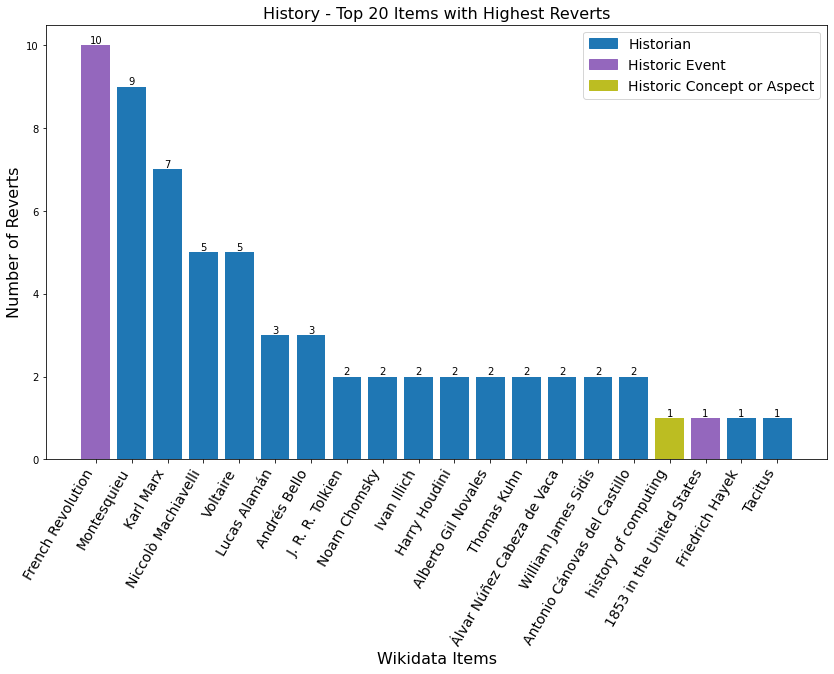

In [107]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_reverts['revert']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

colours = ['tab:purple', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:olive', 'tab:purple', 'tab:blue', 'tab:blue']

historian = mpatches.Patch(color='tab:blue', label='Historian')
historical_event = mpatches.Patch(color='tab:purple', label='Historic Event')
historic_concept = mpatches.Patch(color='tab:olive', label='Historic Concept or Aspect')

plt.legend(handles=[historian, historical_event, historic_concept], fontsize=14)

plt.bar(top20_reverts['label'], top20_reverts['revert'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Reverts", fontsize=16)
plt.title("History - Top 20 Items with Highest Reverts", fontsize=16)
plt.show()

## Top 20 Merges

In [72]:
top20_merges = proxies_without_remove.nlargest(20, 'merge')

In [73]:
top20_merges

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
262,Q91389,0,2,0,0,0,0,12,5
1291,Q21005901,0,2,0,0,0,0,9,2
30,Q2434987,0,1,0,0,0,1,7,2
43,Q2484404,0,1,0,0,0,1,21,16
130,Q1399,5,1,0,0,1,0,25,12
136,Q5736,0,1,0,0,0,0,7,7
138,Q5859,1,1,0,0,0,1,8,8
139,Q5959,1,1,0,0,0,2,11,8
157,Q15975,9,1,1,3,1,0,41,13
229,Q77184,0,1,0,0,0,1,8,6


In [74]:
merge_item_labels = ['Markus Welser', 'Jeff Kingston', 'Timonides of Leucas ', 'Yuval Noah Harari', 'Niccolò Machiavelli',
                     'Amarna', 'Chichen Itza ', 'Quintus Curtius Rufus', 'Montesquieu', 'Leopold von Ranke', 
                     'Louis de Broglie', 'Anglosphere', 'Minhaj-i-Siraj', 'Ivan Maisky', '1994 in art', 
                     'Monte Adranone', 'Nikos Psyroukis', 'Zeev Drori', 'Classic Mac OS', 'Philip Ford']

# Inserting item labels into merge proxies dataframe
top20_merges.insert(1, "label", merge_item_labels, True)

In [75]:
top20_merges

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
262,Q91389,Markus Welser,0,2,0,0,0,0,12,5
1291,Q21005901,Jeff Kingston,0,2,0,0,0,0,9,2
30,Q2434987,Timonides of Leucas,0,1,0,0,0,1,7,2
43,Q2484404,Yuval Noah Harari,0,1,0,0,0,1,21,16
130,Q1399,Niccolò Machiavelli,5,1,0,0,1,0,25,12
136,Q5736,Amarna,0,1,0,0,0,0,7,7
138,Q5859,Chichen Itza,1,1,0,0,0,1,8,8
139,Q5959,Quintus Curtius Rufus,1,1,0,0,0,2,11,8
157,Q15975,Montesquieu,9,1,1,3,1,0,41,13
229,Q77184,Leopold von Ranke,0,1,0,0,0,1,8,6


Text(0.5, 1.0, 'History - Top 20 Items with Highest Merges')

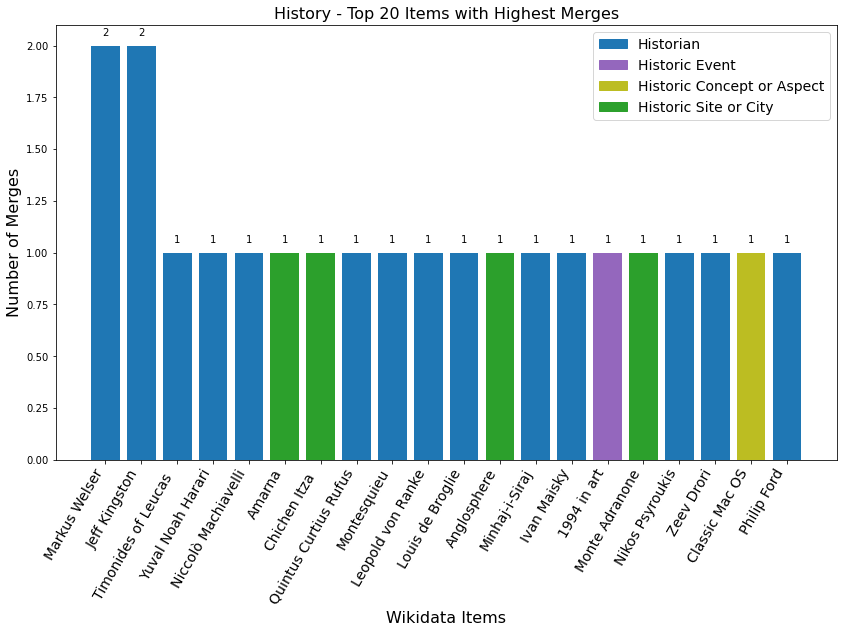

In [108]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_merges['merge']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')
    

colours = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:green', 'tab:green', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:green', 'tab:blue', 'tab:blue', 'tab:purple',
           'tab:green', 'tab:blue', 'tab:blue', 'tab:olive', 'tab:blue']

historian = mpatches.Patch(color='tab:blue', label='Historian')
historical_event = mpatches.Patch(color='tab:purple', label='Historic Event')
historic_concept = mpatches.Patch(color='tab:olive', label='Historic Concept or Aspect')
historic_site = mpatches.Patch(color='tab:green', label='Historic Site or City')

plt.legend(handles=[historian, historical_event, historic_concept, historic_site], fontsize=14)

plt.bar(top20_merges['label'], top20_merges['merge'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Merges", fontsize=16)
plt.title("History - Top 20 Items with Highest Merges", fontsize=16)

## Top 20 Undos

In [78]:
top20_undos = proxies_without_remove.nlargest(20, 'undo')

In [79]:
top20_undos

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
583,Q3679366,1,0,5,0,0,1,13,4
75,Q2641849,0,0,3,0,0,9,14,3
141,Q6534,10,0,3,2,0,2,41,12
1561,Q185381,0,0,3,0,0,1,18,6
123,Q220,0,0,2,0,0,1,36,21
350,Q507298,3,0,2,0,0,0,26,5
804,Q5870609,1,0,2,0,0,1,7,3
838,Q6278197,0,0,2,0,0,1,9,3
1109,Q13522376,0,1,2,0,0,0,12,4
87,Q2735691,1,0,1,0,0,0,9,4


In [80]:
undo_item_labels = ['history of Facebook', 'history of Limousin', 'French Revolution', 'Arnold J. Toynbee', 'Rome',
                     'Lucas Alamán', 'history of the US Republican Party', 'Jorge Lanata', 'Classic Mac OS', 'history of computing', 
                     'Antonio García de León', 'Alexander Pushkin', 'Montesquieu', 'Eratosthenes', 'Capernaum', 
                     'Washington Irving', 'Anglosphere', 'David Gans', 'Enzo Traverso', 'Pierre Demargne']

# Inserting item labels into undo proxies dataframe
top20_undos.insert(1, "label", undo_item_labels, True)

In [81]:
top20_undos

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
583,Q3679366,history of Facebook,1,0,5,0,0,1,13,4
75,Q2641849,history of Limousin,0,0,3,0,0,9,14,3
141,Q6534,French Revolution,10,0,3,2,0,2,41,12
1561,Q185381,Arnold J. Toynbee,0,0,3,0,0,1,18,6
123,Q220,Rome,0,0,2,0,0,1,36,21
350,Q507298,Lucas Alamán,3,0,2,0,0,0,26,5
804,Q5870609,history of the US Republican Party,1,0,2,0,0,1,7,3
838,Q6278197,Jorge Lanata,0,0,2,0,0,1,9,3
1109,Q13522376,Classic Mac OS,0,1,2,0,0,0,12,4
87,Q2735691,history of computing,1,0,1,0,0,0,9,4


Text(0.5, 1.0, 'History - Top 20 Items with Highest Undos')

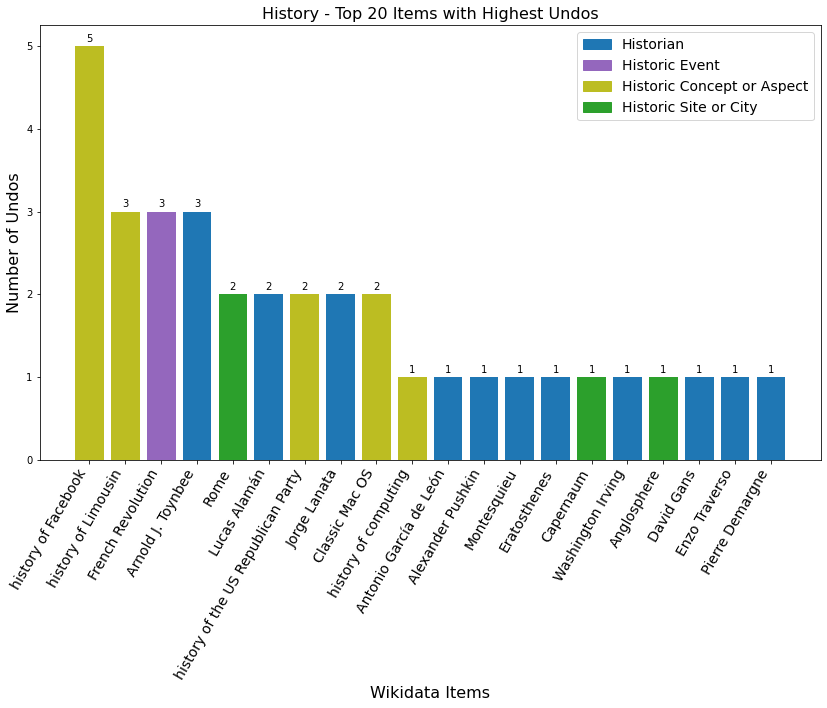

In [109]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_undos['undo']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')
    
colours = ['tab:olive', 'tab:olive', 'tab:purple', 'tab:blue', 'tab:green',
           'tab:blue', 'tab:olive', 'tab:blue', 'tab:olive', 'tab:olive',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:green',
           'tab:blue', 'tab:green', 'tab:blue', 'tab:blue', 'tab:blue']

historian = mpatches.Patch(color='tab:blue', label='Historian')
historical_event = mpatches.Patch(color='tab:purple', label='Historic Event')
historic_concept = mpatches.Patch(color='tab:olive', label='Historic Concept or Aspect')
historic_site = mpatches.Patch(color='tab:green', label='Historic Site or City')

plt.legend(handles=[historian, historical_event, historic_concept, historic_site], fontsize=14)

plt.bar(top20_undos['label'], top20_undos['undo'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Undos", fontsize=16)
plt.title("History - Top 20 Items with Highest Undos", fontsize=16)

## Top 20 Restores

In [83]:
top20_restores = proxies_without_remove.nlargest(20, 'restore')

In [84]:
top20_restores

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
150,Q9061,7,0,0,3,0,4,45,19
157,Q15975,9,1,1,3,1,0,41,13
141,Q6534,10,0,3,2,0,2,41,12
127,Q892,2,0,0,1,0,1,40,15
133,Q2161,1,0,0,1,0,1,19,9
137,Q5738,0,0,0,1,0,1,25,7
147,Q9038,0,0,0,1,0,2,21,8
151,Q9068,5,0,0,1,0,0,27,15
161,Q25351,0,0,0,1,0,0,15,9
172,Q42511,1,0,0,1,0,0,28,13


In [85]:
restore_item_labels = ['Karl Marx', 'Montesquieu', 'French Revolution', 'J. R. R. Tolkien', 'Tacitus',
                     'Adolphe Thiers', 'Al-Khwarizmi', 'Voltaire', 'Theodor Mommsen', 'H.G. Wells', 
                     'history of India', 'Gaston Paris', '1927 in Taiwan', 'Armando López Macip', 'Ľudovít Štúr', 
                     'Bernal Díaz del Castillo', 'Andrés Bello', 'history of the automobile', 'Zygmunt Radzimiński', '1940 in Taiwan']

# Inserting item labels into restore proxies dataframe
top20_restores.insert(1, "label", restore_item_labels, True)

In [86]:
top20_restores

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
150,Q9061,Karl Marx,7,0,0,3,0,4,45,19
157,Q15975,Montesquieu,9,1,1,3,1,0,41,13
141,Q6534,French Revolution,10,0,3,2,0,2,41,12
127,Q892,J. R. R. Tolkien,2,0,0,1,0,1,40,15
133,Q2161,Tacitus,1,0,0,1,0,1,19,9
137,Q5738,Adolphe Thiers,0,0,0,1,0,1,25,7
147,Q9038,Al-Khwarizmi,0,0,0,1,0,2,21,8
151,Q9068,Voltaire,5,0,0,1,0,0,27,15
161,Q25351,Theodor Mommsen,0,0,0,1,0,0,15,9
172,Q42511,H.G. Wells,1,0,0,1,0,0,28,13


Text(0.5, 1.0, 'History - Top 20 Items with Highest Restores')

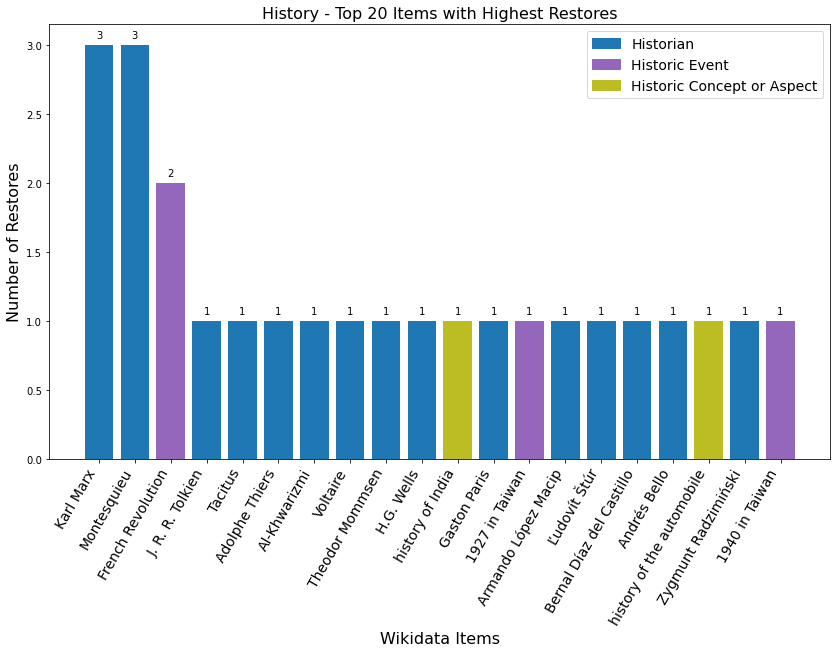

In [110]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_restores['restore']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

    
colours = ['tab:blue', 'tab:blue', 'tab:purple', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:olive', 'tab:blue', 'tab:purple', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:olive', 'tab:blue', 'tab:purple']

historian = mpatches.Patch(color='tab:blue', label='Historian')
historical_event = mpatches.Patch(color='tab:purple', label='Historic Event')
historic_concept = mpatches.Patch(color='tab:olive', label='Historic Concept or Aspect')
historic_site = mpatches.Patch(color='tab:green', label='Historic Site or City')

plt.legend(handles=[historian, historical_event, historic_concept], fontsize=14)

plt.bar(top20_restores['label'], top20_restores['restore'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Restores", fontsize=16)
plt.title("History - Top 20 Items with Highest Restores", fontsize=16)

## Top 20 Edits

In [89]:
top20_edits = proxies_without_remove.nlargest(20, 'editscount')

In [90]:
top20_edits

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
601,Q3827806,1,0,0,0,0,26,125,33
1413,Q27892175,0,0,1,0,0,4,102,5
2225,Q22058817,0,0,1,0,0,5,94,3
1430,Q27915619,0,0,1,0,0,2,74,5
676,Q4864705,0,0,1,0,0,10,59,6
2533,Q27826654,0,0,1,0,0,1,52,3
150,Q9061,7,0,0,3,0,4,45,19
835,Q6018302,0,0,1,0,0,2,45,4
145,Q8016,1,0,0,0,0,0,44,13
141,Q6534,10,0,3,2,0,2,41,12


In [91]:
edit_item_labels = ['Laura Mancinelli', 'Sunweb 2017', 'ERA Real Estate-Circus 2016', 'Orica-Scott 2017', 'Barry S. Strauss',
                     '2017 Israel Cycling Academy', 'Karl Marx', 'Mirta Núñez', 'Winston Churchill', 'French Revolution', 
                     'Montesquieu', 'J. R. R. Tolkien ', 'Rome', 'Caja Rural-Seguros RGA 2017', 'H.G. Wells',  
                     'Sauerland NRW-Henley & Partners 2016', 'Voltaire', 'Johannes Nicolai', 'Louis de Broglie', 'history of India']

# Inserting item labels into edit proxies dataframe
top20_edits.insert(1, "label", edit_item_labels, True)

In [92]:
top20_edits

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
601,Q3827806,Laura Mancinelli,1,0,0,0,0,26,125,33
1413,Q27892175,Sunweb 2017,0,0,1,0,0,4,102,5
2225,Q22058817,ERA Real Estate-Circus 2016,0,0,1,0,0,5,94,3
1430,Q27915619,Orica-Scott 2017,0,0,1,0,0,2,74,5
676,Q4864705,Barry S. Strauss,0,0,1,0,0,10,59,6
2533,Q27826654,2017 Israel Cycling Academy,0,0,1,0,0,1,52,3
150,Q9061,Karl Marx,7,0,0,3,0,4,45,19
835,Q6018302,Mirta Núñez,0,0,1,0,0,2,45,4
145,Q8016,Winston Churchill,1,0,0,0,0,0,44,13
141,Q6534,French Revolution,10,0,3,2,0,2,41,12


Text(0.5, 1.0, 'History - Top 20 Items with Highest Edits')

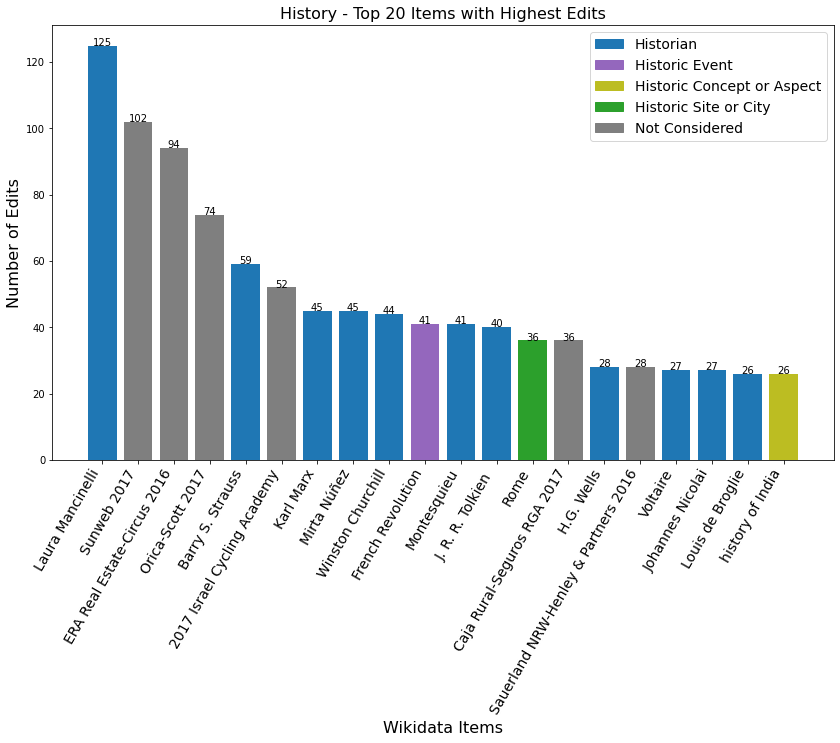

In [111]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_edits['editscount']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')


colours = ['tab:blue', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:blue',
           'tab:gray', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:purple',
           'tab:blue', 'tab:blue', 'tab:green', 'tab:gray', 'tab:blue',
           'tab:gray', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:olive']

historian = mpatches.Patch(color='tab:blue', label='Historian')
historical_event = mpatches.Patch(color='tab:purple', label='Historic Event')
historic_concept = mpatches.Patch(color='tab:olive', label='Historic Concept or Aspect')
historic_site = mpatches.Patch(color='tab:green', label='Historic Site or City')
not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')

plt.legend(handles=[historian, historical_event, historic_concept, historic_site, not_considered], fontsize=14)

plt.bar(top20_edits['label'], top20_edits['editscount'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Edits", fontsize=16)
plt.title("History - Top 20 Items with Highest Edits", fontsize=16)

## Top 20 Users

In [95]:
top20_users = proxies_without_remove.nlargest(20, 'userscount')

In [96]:
top20_users

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
601,Q3827806,1,0,0,0,0,26,125,33
123,Q220,0,0,2,0,0,1,36,21
150,Q9061,7,0,0,3,0,4,45,19
43,Q2484404,0,1,0,0,0,1,21,16
127,Q892,2,0,0,1,0,1,40,15
151,Q9068,5,0,0,1,0,0,27,15
145,Q8016,1,0,0,0,0,0,44,13
157,Q15975,9,1,1,3,1,0,41,13
172,Q42511,1,0,0,1,0,0,28,13
130,Q1399,5,1,0,0,1,0,25,12


In [97]:
user_item_labels = ['Laura Mancinelli', 'Rome', 'Karl Marx', 'Yuval Noah Harari', 'J. R. R. Tolkien',
                     'Voltaire', 'Winston Churchill', 'Montesquieu', 'H.G. Wells', 'Niccolò Machiavelli', 
                     'French Revolution', 'Alexander Pushkin ', 'Noam Chomsky', 'Guðni Jóhannesson', 'Ibn Khaldun',  
                     '2017 in film', 'historian', 'Moses of Chorene', 'Friedrich Hayek', 'Tacitus']

# Inserting item labels into user proxies dataframe
top20_users.insert(1, "label", user_item_labels, True)

In [98]:
top20_users

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
601,Q3827806,Laura Mancinelli,1,0,0,0,0,26,125,33
123,Q220,Rome,0,0,2,0,0,1,36,21
150,Q9061,Karl Marx,7,0,0,3,0,4,45,19
43,Q2484404,Yuval Noah Harari,0,1,0,0,0,1,21,16
127,Q892,J. R. R. Tolkien,2,0,0,1,0,1,40,15
151,Q9068,Voltaire,5,0,0,1,0,0,27,15
145,Q8016,Winston Churchill,1,0,0,0,0,0,44,13
157,Q15975,Montesquieu,9,1,1,3,1,0,41,13
172,Q42511,H.G. Wells,1,0,0,1,0,0,28,13
130,Q1399,Niccolò Machiavelli,5,1,0,0,1,0,25,12


Text(0.5, 1.0, 'History - Top 20 Items with Highest Users')

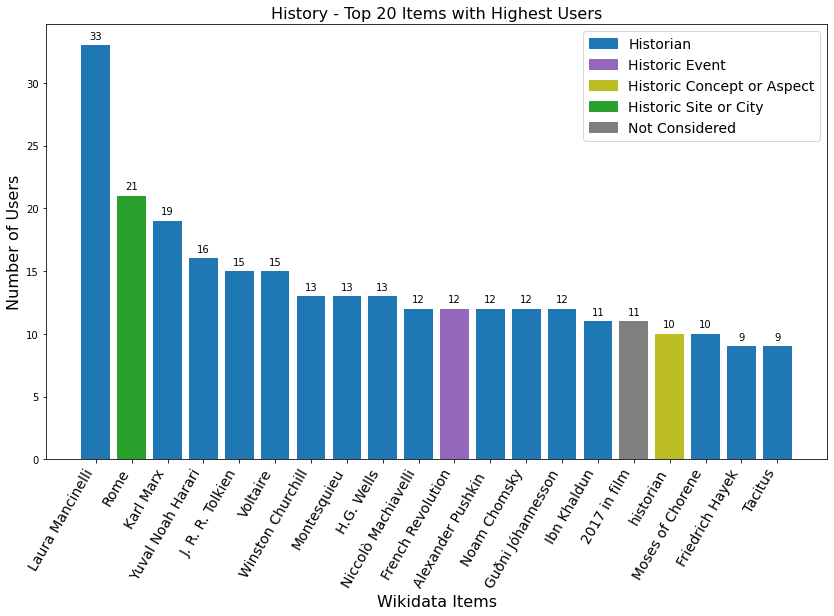

In [112]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_users['userscount']):
    ax.text(i, r+0.5, str(r), horizontalalignment='center')


colours = ['tab:blue', 'tab:green', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:purple', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:gray', 'tab:olive', 'tab:blue', 'tab:blue', 'tab:blue']

historian = mpatches.Patch(color='tab:blue', label='Historian')
historical_event = mpatches.Patch(color='tab:purple', label='Historic Event')
historic_concept = mpatches.Patch(color='tab:olive', label='Historic Concept or Aspect')
historic_site = mpatches.Patch(color='tab:green', label='Historic Site or City')
not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')

plt.legend(handles=[historian, historical_event, historic_concept, historic_site, not_considered], fontsize=14)

plt.bar(top20_users['label'], top20_users['userscount'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Users", fontsize=16)
plt.title("History - Top 20 Items with Highest Users", fontsize=16)

# Selecting Specific Items

In [102]:
# Finding most commonly occurring items in proxies revert, merge, restore and undo
data_frames = [top20_reverts, top20_merges, top20_undos, top20_restores, top20_edits, top20_users]
common_items = pd.concat(data_frames)

In [103]:
common_items_count = common_items['qid'].value_counts()
common_20 = common_items_count.nlargest(20)
print("Items and the number of times they occurred in top 20 reverts, merges, restores and undos")
print(common_20)

Items and the number of times they occurred in top 20 reverts, merges, restores and undos
Q15975       6
Q6534        5
Q892         4
Q9068        4
Q9061        4
Q220         3
Q1399        3
Q2161        3
Q42511       3
Q1325        2
Q13522376    2
Q83331       2
Q507298      2
Q2735691     2
Q133136      2
Q9049        2
Q439195      2
Q8016        2
Q2484404     2
Q7200        2
Name: qid, dtype: int64


Based on the above information and using assumption-3 that items with a diverse range of proxies would be interesting to look at, the following items were selecetd.

- Montesquieu (Q15975)
- French Revolution (Q6534)
- Karl Marx (Q9061)

In [105]:
# Storing the revisions of the selected items in CSV files
# rev[rev['qid'] == 'Q15975'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/history/Montesquieu_Q15975.csv')
# rev[rev['qid'] == 'Q6534'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/history/French Revolution_Q6534.csv')
# rev[rev['qid'] == 'Q9061'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/history/Karl Marx_Q9061.csv')